In [1]:
import pandas as pd
import numpy as np
import datetime


from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Bidirectional, Dropout, BatchNormalization, InputLayer
#from tensorflow_addons.metrics import RSquare


import warnings
warnings.filterwarnings('ignore')

# To avoid tensorflow warnings. Can be removed if not required
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tqdm import tqdm 

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

In [3]:
def scheduler(epoch, lr):
    if epoch>4 and epoch%5==0:
        lr=lr*0.5
    return lr

def record_lr(epoch, lr):
    learning_rates.append(lr)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
  

## Pre Processing

In [4]:
df=pd.read_csv('Pollution_data.csv')
pollutant='PM2.5'
station_name=df['siteName'].unique()[0]
df['from date']=pd.to_datetime(df['from date'])
df['mins']=df['from date'].dt.minute
df=df[df['mins']==0].reset_index()[['from date',pollutant]] # Converted to Hourly dataframe
display(df.head())
print('Converted to Hourly Data from 15 min data')
timestamp_s =pd.to_datetime(df['from date']).map(datetime.datetime.timestamp)
day=24 * 60 * 60
year=365.25*day

#df['day_sin']=np.sin(timestamp_s*2*np.pi/(day))
#df['day_cos']=np.cos(timestamp_s*2*np.pi/(day))
#df['year_sin']=np.sin(timestamp_s*2*np.pi/(year))
#df['year_cos']=np.cos(timestamp_s*2*np.pi/(year))

#df['year']=df['from date'].dt.year
df=df[[pollutant]]
#df=df[['day_sin','day_cos','year_sin','year_cos',pollutant]]
#df=df[(df.year==2020)|(df.year==2021)][['from date',pollutant]].reset_index(drop=True)
#df=df[(df.year==2020)][['from date',pollutant]].reset_index(drop=True)
print(f'NaN Percentage : {df[pollutant].isna().sum()/len(df)*100 :.2f} %')
print("\nFilling Missing Values using Linear Interpolation")
print("Processing...")
# Lets Fill Missing Values with Linear Interpolation
df[pollutant]=linear_int(df[pollutant])
print("Finished Interpolation")

df.head()

,from date,PM2.5
0,2018-09-13 12:00:00,20.0
1,2018-09-13 13:00:00,24.0
2,2018-09-13 14:00:00,25.0
3,2018-09-13 15:00:00,27.0
4,2018-09-13 16:00:00,27.0


Converted to Hourly Data from 15 min data
NaN Percentage : 2.77 %

Filling Missing Values using Linear Interpolation
Processing...
Finished Interpolation


,PM2.5
0,20.0
1,24.0
2,25.0
3,27.0
4,27.0


In [5]:
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## Naive model

In [6]:
naive_result=test_df['PM2.5'].shift(24)

In [7]:
naive=np.array(list(naive_result.dropna().reset_index(drop=True).values))

## Time Series Model
---
Input Width = 24;
Target Width = 1;
Shift = 24
1. Naive Model: Previous days value at that time
2. Nueral Networks

### Nueral Networks Model

In [8]:
inp_width=24
pred_with=1
tot_length=inp_width+24
shift=1
batch_size=128

train_data = tf.data.Dataset.from_tensor_slices(train_df.values) 
train_data = train_data.window(tot_length, shift=shift, drop_remainder=True)
train_data = train_data.flat_map(lambda x: x.batch(tot_length))
train_data = train_data.map(lambda x: (x[:inp_width], x[-pred_with:]))
train_data = train_data.shuffle(1000)
train_data = train_data.batch(batch_size).prefetch(1)
for i,j in train_data.take(1):
    print('Input Shape:',i.shape)
    print('Output Shape:',j.shape)
    break

Input Shape: (128, 24, 1)
Output Shape: (128, 1, 1)


In [9]:
def create_dataset(data,inp_width,targets_width,tot_length,shift,batch_size,to_shuffle=True):
    train_data = tf.data.Dataset.from_tensor_slices(data) 
    train_data = train_data.window(tot_length, shift=shift, drop_remainder=True)
    train_data = train_data.flat_map(lambda x: x.batch(tot_length))
    train_data = train_data.map(lambda x: (x[:inp_width], x[-targets_width:]))
    if to_shuffle:
        train_data = train_data.shuffle(1000)
    train_data = train_data.batch(batch_size).prefetch(1)
    return train_data

In [10]:
train_data=create_dataset(train_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=True)
val_data=create_dataset(val_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=True)
test_data=create_dataset(test_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=False)

for inp, target in train_data.take(1):
    print('Input Shape :',np.shape(inp))
    print('Output Shape :',np.shape(target))
    #print("Features:", inp.numpy())
    #print("Target:", target.numpy())
    break

Input Shape : (128, 24, 1)
Output Shape : (128, 1, 1)


In [11]:
lstm_model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[inp_width]), #or use np.shape(inp)[1] of above cell
    Bidirectional(LSTM(64)),
    Dense(256, activation='relu'),
    Dense(1)
])

lstm_model.compile(loss=MeanSquaredError(),optimizer=Adam(),metrics=['mae'])
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 24, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 67073 (262.00 KB)
Trainable params: 67073 (262.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
learning_rates = []  # To store learning rates

#model_name.optimizer in next line to be used
record_lr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: record_lr(epoch, lstm_model.optimizer.lr.numpy()))

lstm_history = lstm_model.fit(
    train_data,epochs=100,
    callbacks=[early_stopping,record_lr_callback,lr_scheduler],
    validation_data=val_data,shuffle=True,
    #verbose=1
    )

Epoch 1/100


240/240 [==============================] - 7s 19ms/step - loss: 0.0017 - mae: 0.0240 - val_loss: 5.8047e-04 - val_mae: 0.0147 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 4s 15ms/step - loss: 7.2185e-04 - mae: 0.0162 - val_loss: 4.2624e-04 - val_mae: 0.0127 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 4s 15ms/step - loss: 6.1697e-04 - mae: 0.0147 - val_loss: 3.9943e-04 - val_mae: 0.0121 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 4s 15ms/step - loss: 6.1381e-04 - mae: 0.0147 - val_loss: 4.0796e-04 - val_mae: 0.0124 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 4s 16ms/step - loss: 5.9542e-04 - mae: 0.0146 - val_loss: 3.9591e-04 - val_mae: 0.0121 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 4s 16ms/step - loss: 5.7926e-04 - mae: 0.0141 - val_loss: 3.9507e-04 - val_mae: 0.0122 - lr: 5.0000e-04
Epoch 7/100
240/240 [==============================] - 4s 16ms/step 

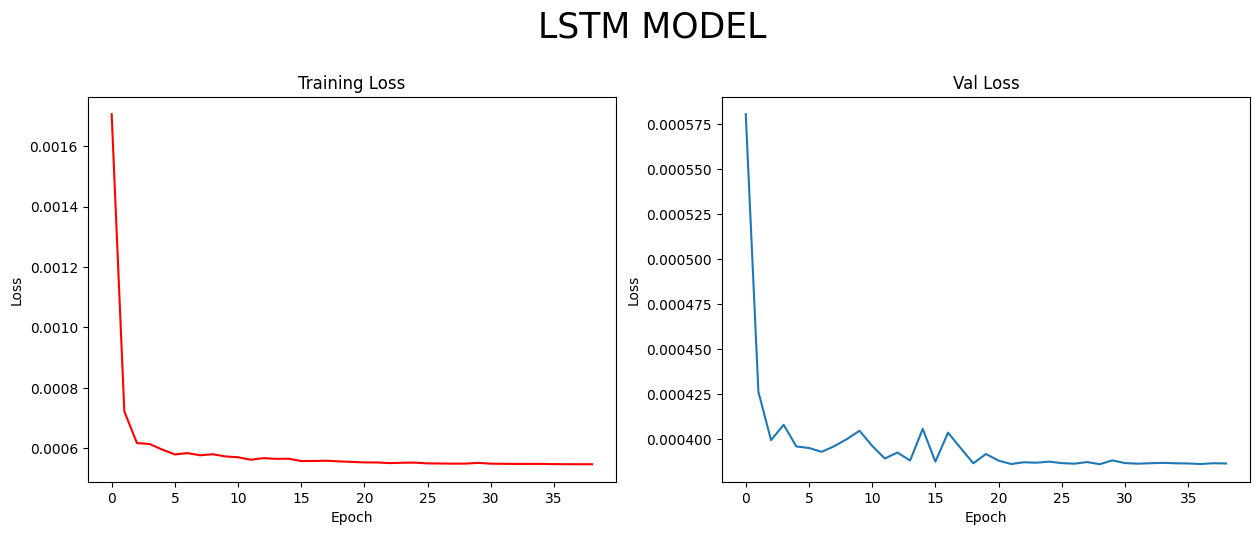

					FINAL LOSS: 0.00055 | FINAL MAE: 0.01358


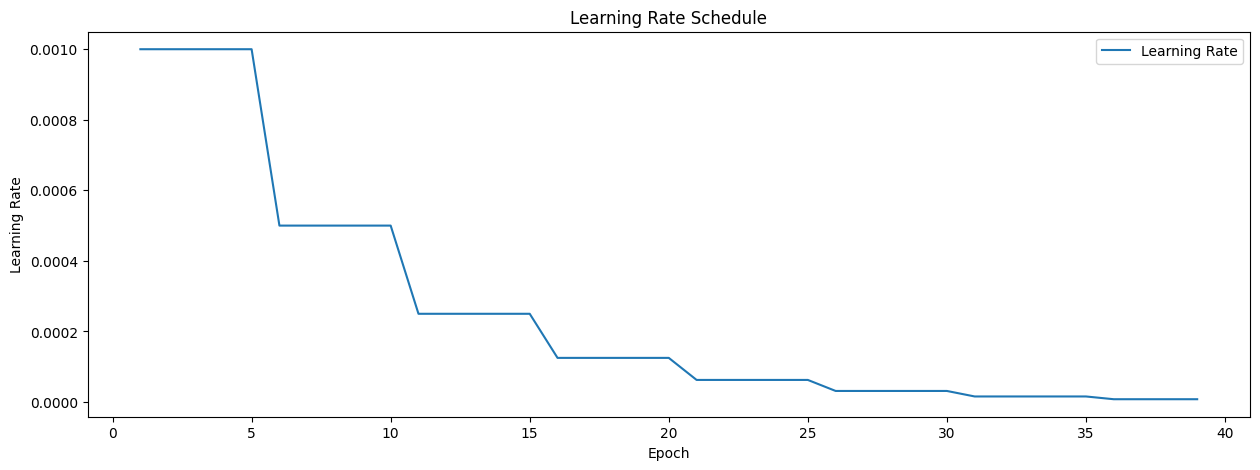

In [13]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Val Loss')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 5),
                                                 round(lstm_history.history['mae'][-1] ,5)))

epochs = range(1, len(learning_rates) + 1)
plt.plot(epochs, learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [14]:
test_pred=lstm_model.predict(test_data).reshape(-1)
y_test=[]
for inp,lab in test_data:
    y_test+=list(lab.numpy().reshape(-1))
print('Naive Model MAE:',np.abs(test_df['PM2.5'][24:].values - naive).sum()/len(test_df['PM2.5'][24:]))
print('LSTM Model MAE:',np.sum(np.abs(np.array(list(test_pred))-np.array(y_test)))/len(test_df))

35/35 [==============================] - 1s 16ms/step
Naive Model MAE: 0.02255334515872099
LSTM Model MAE: 0.00829857898724657


### Nueral Net Model with time transformed as features

#### Pre Processing

In [15]:
df=pd.read_csv('Pollution_data.csv')
pollutant='PM2.5'
station_name=df['siteName'].unique()[0]
df['from date']=pd.to_datetime(df['from date'])
df['mins']=df['from date'].dt.minute
df=df[df['mins']==0].reset_index()[['from date',pollutant]] # Converted to Hourly dataframe
display(df.head())
print('Converted to Hourly Data from 15 min data')
timestamp_s =pd.to_datetime(df['from date']).map(datetime.datetime.timestamp)
day=24 * 60 * 60
year=365.25*day

df['day_sin']=np.sin(timestamp_s*2*np.pi/(day))
df['day_cos']=np.cos(timestamp_s*2*np.pi/(day))
df['year_sin']=np.sin(timestamp_s*2*np.pi/(year))
df['year_cos']=np.cos(timestamp_s*2*np.pi/(year))

#df['year']=df['from date'].dt.year
#df=df[[pollutant]]
df=df[['day_sin','day_cos','year_sin','year_cos',pollutant]]
#df=df[(df.year==2020)|(df.year==2021)][['from date',pollutant]].reset_index(drop=True)
#df=df[(df.year==2020)][['from date',pollutant]].reset_index(drop=True)
print(f'NaN Percentage : {df[pollutant].isna().sum()/len(df)*100 :.2f} %')
print("\nFilling Missing Values using Linear Interpolation")
print("Processing...")
# Lets Fill Missing Values with Linear Interpolation
df[pollutant]=linear_int(df[pollutant])
print("Finished Interpolation")

df.head()

,from date,PM2.5
0,2018-09-13 12:00:00,20.0
1,2018-09-13 13:00:00,24.0
2,2018-09-13 14:00:00,25.0
3,2018-09-13 15:00:00,27.0
4,2018-09-13 16:00:00,27.0


Converted to Hourly Data from 15 min data
NaN Percentage : 2.77 %

Filling Missing Values using Linear Interpolation
Processing...
Finished Interpolation


,day_sin,day_cos,year_sin,year_cos,PM2.5
0,0.991445,-0.130526,-0.948885,-0.315622,20.0
1,0.923880,-0.382683,-0.949111,-0.314942,24.0
2,0.793353,-0.608761,-0.949337,-0.314261,25.0
3,0.608761,-0.793353,-0.949562,-0.313581,27.0
4,0.382683,-0.923880,-0.949786,-0.312900,27.0


In [16]:
# Splitting and Scaling
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

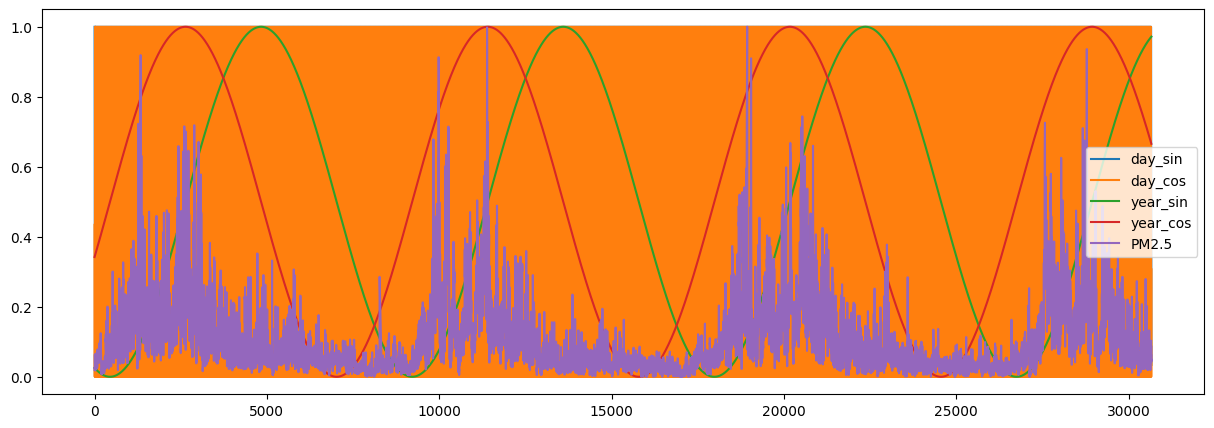

In [17]:
train_df.plot()
plt.show()

#### Modelling

In [18]:
df

,day_sin,day_cos,year_sin,year_cos,PM2.5
0,0.991445,-0.130526,-0.948885,-0.315622,20.0
1,0.923880,-0.382683,-0.949111,-0.314942,24.0
2,0.793353,-0.608761,-0.949337,-0.314261,25.0
3,0.608761,-0.793353,-0.949562,-0.313581,27.0
4,0.382683,-0.923880,-0.949786,-0.312900,27.0
...,...,...,...,...,...
43795,0.382683,0.923880,-0.940669,-0.339325,40.0
43796,0.608761,0.793353,-0.940912,-0.338650,38.0
43797,0.793353,0.608761,-0.941155,-0.337976,20.0
43798,0.923880,0.382683,-0.941397,-0.337301,20.0


In [19]:
def create_dataset_ts(df,window,inp_len):
    inp_list=[]
    out=[]
    pbar = tqdm(total=len(df)-window)
    for ind,row in df[window:].iterrows():
        inp=[]
        inp.append(row['day_sin'])
        inp.append(row['day_cos'])
        inp.append(row['year_sin'])
        inp.append(row['year_cos'])
        for i in range(ind-window,ind):
            inp.append(df.loc[i]['PM2.5'])
        inp_list.append(inp)
        out.append(row['PM2.5'])
        pbar.update(1)
    inp_list=np.array(inp_list)
    out=np.array(out)

    inp_list=np.reshape(inp_list,(inp_list.shape[0],1,inp_list.shape[1]))
    return  inp_list,out


In [20]:
inp,out=create_dataset_ts(train_df,25,24)
inp_val,out_val=create_dataset_ts(val_df,25,24)
inp_test,out_test=create_dataset_ts(test_df,25,24)
inp.shape,out.shape

100%|██████████| 4355/4355 [00:05<00:00, 760.35it/s]


((30634, 1, 29), (30634,))

In [21]:
inp_val,out_val=create_dataset_ts(val_df,25,24)
inp_test,out_test=create_dataset_ts(test_df,25,24)

100%|██████████| 4355/4355 [00:05<00:00, 737.38it/s]


In [22]:
dnn_model = Sequential([
    Dense(256, activation='relu',input_shape=(inp_val.shape[1], inp_val.shape[2])),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1),
])
dnn_model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['mae']
)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 256)            7680      
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 dense_3 (Dense)             (None, 1, 512)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 512)            0         
                                                                 
 dense_4 (Dense)             (None, 1, 512)            262656    
                                                                 
 dropout_2 (Dropout)         (None, 1, 512)            0         
                                                                 
 dense_5 (Dense)             (None, 1, 1)             

In [23]:
learning_rates = []  # To store learning rates

def record_lr(epoch, lr):
    learning_rates.append(lr)

record_lr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: record_lr(epoch, dnn_model.optimizer.lr.numpy()))

dnn_model_history = dnn_model.fit(x=inp,y=out,epochs=100,
                                  callbacks=[early_stopping,record_lr_callback,lr_scheduler],
                                  validation_data=[inp_val,out_val],shuffle=True,batch_size=128,verbose=0)

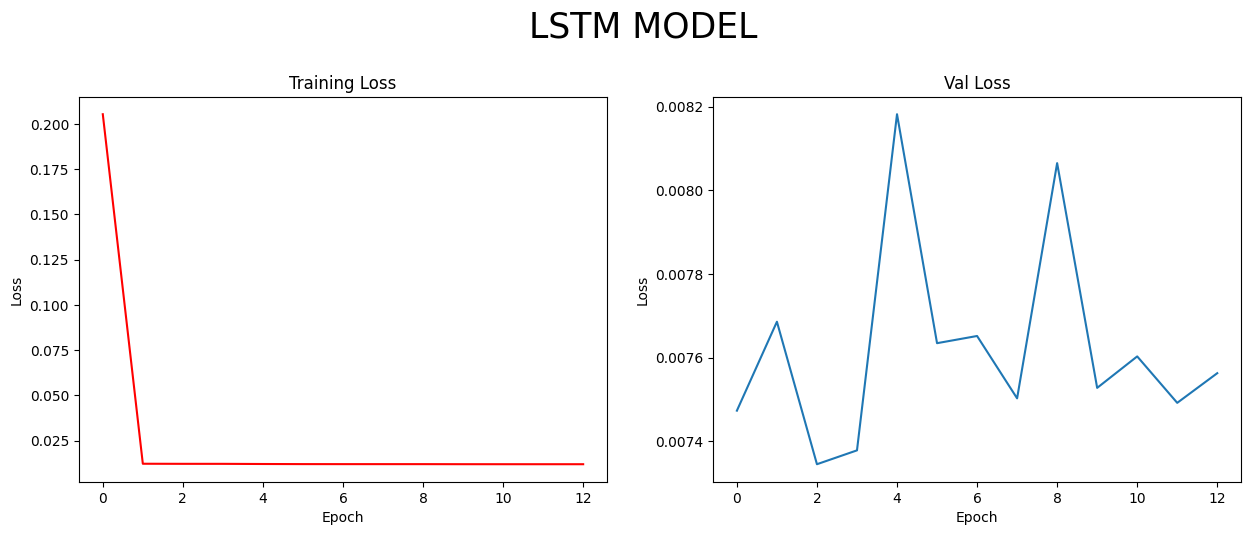

					FINAL LOSS: 0.00055 | FINAL MAE: 0.01358


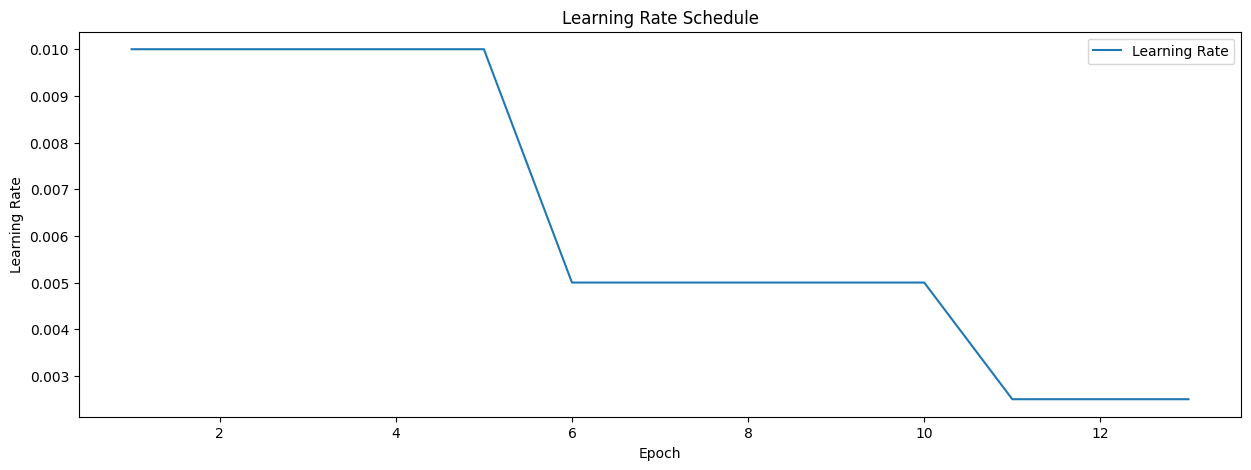

In [24]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(dnn_model_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(dnn_model_history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Val Loss')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 5),
                                                 round(lstm_history.history['mae'][-1] ,5)))

epochs = range(1, len(learning_rates) + 1)
plt.plot(epochs, learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [25]:
test_pred_2=dnn_model.predict(inp_test).reshape(-1)
print('Naive Model MAE:',np.abs(test_df['PM2.5'][24:].values - naive).sum()/len(test_df['PM2.5'][24:]))
print('Simple LSTM Model MAE:',np.sum(np.abs(np.array(list(test_pred))-np.array(y_test)))/len(test_df))
print('LSTM with time featues Model MAE:',np.sum(np.abs(np.array(list(test_pred_2))-np.array(out_test)))/len(test_df))


137/137 [==============================] - 0s 2ms/step
Naive Model MAE: 0.02255334515872099
Simple LSTM Model MAE: 0.00829857898724657
LSTM with time featues Model MAE: 0.0697248070455662


##### DNN model is not as great as LSTM model. Thus we use that